### Keras and Tensorflow Neural Network (NN)

In [10]:
import pandas as pd
from processing_utils import *

raw_dataset = pd.read_csv('./dataset/data.csv')

pruned_dataset = prune_dataset_lines(raw_dataset, remove_nan_lines=False, remove_nan_cols=True)
print("Raw dataset shape =", raw_dataset.shape, " Pruned dataset shape =", pruned_dataset.shape)

encoded_pruned_data = encode_smiles_column_of(pruned_dataset, 'count_encoding') # change to one_hot_encoding here
print("Encoded dataset shape =", encoded_pruned_data.shape)

X_train, y_train, X_val, y_val, X_test, y_test = return_required_data(
    encoded_pruned_data, 
    ['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'], 
    normalize=True
)

Raw dataset shape = (39926, 24)  Pruned dataset shape = (12865, 6)
Encoded dataset shape = (12865, 35)


### Tiny Neural Networks with SGD gradient descent

In [11]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

tiny_model_Energy_ = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=33),
    keras.layers.Dense(1)   
])

tiny_model_Energy_.compile(
    loss='mse', 
    optimizer=SGD(learning_rate=1e-3, momentum=0), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
) 

tiny_model_EnergyDG = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_dim=33),
    keras.layers.Dense(1)   
])

tiny_model_EnergyDG.compile(
    loss='mse', 
    optimizer=SGD(learning_rate=1e-3, momentum=0), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9005, 33) (9005, 2) (1158, 33) (1158, 2)


In [12]:
sgd_histories = {}

# TODO : optimize patience parameter via Optuna.
# this callback is used to do early stopping in case val_loss doesn't improve for 10 epochs
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# HUGO TODO : fine tune gradient/model hyperparameters via Optuna, epochs is model hyperparam, batch_size is stochastic descent hyperparameter
# number of instances to be used to compute gradient update
# nb : n_epochs 
sgd_histories['tiny_Energy_'] = tiny_model_Energy_.fit(X_train, y_train[:, 0], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 0]), callbacks=[es])
sgd_histories['tiny_EnergyDG'] = tiny_model_EnergyDG.fit(X_train, y_train[:, 1], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 1]), callbacks=[es])


Epoch 1/150
19/19 [==============================] - 0s 9ms/step - loss: 1.5115 - mse: 1.5115 - r_square: -0.5115 - val_loss: 1.2306 - val_mse: 1.2306 - val_r_square: -0.2306
Epoch 2/150
19/19 [==============================] - 0s 2ms/step - loss: 1.1204 - mse: 1.1204 - r_square: -0.1204 - val_loss: 0.9668 - val_mse: 0.9668 - val_r_square: 0.0332
Epoch 3/150
19/19 [==============================] - 0s 3ms/step - loss: 0.9060 - mse: 0.9060 - r_square: 0.0940 - val_loss: 0.8032 - val_mse: 0.8032 - val_r_square: 0.1968
Epoch 4/150
19/19 [==============================] - 0s 2ms/step - loss: 0.7679 - mse: 0.7679 - r_square: 0.2321 - val_loss: 0.6926 - val_mse: 0.6926 - val_r_square: 0.3074
Epoch 5/150
19/19 [==============================] - 0s 2ms/step - loss: 0.6715 - mse: 0.6715 - r_square: 0.3285 - val_loss: 0.6157 - val_mse: 0.6157 - val_r_square: 0.3843
Epoch 6/150
19/19 [==============================] - 0s 2ms/step - loss: 0.6024 - mse: 0.6024 - r_square: 0.3976 - val_loss: 0.5509 

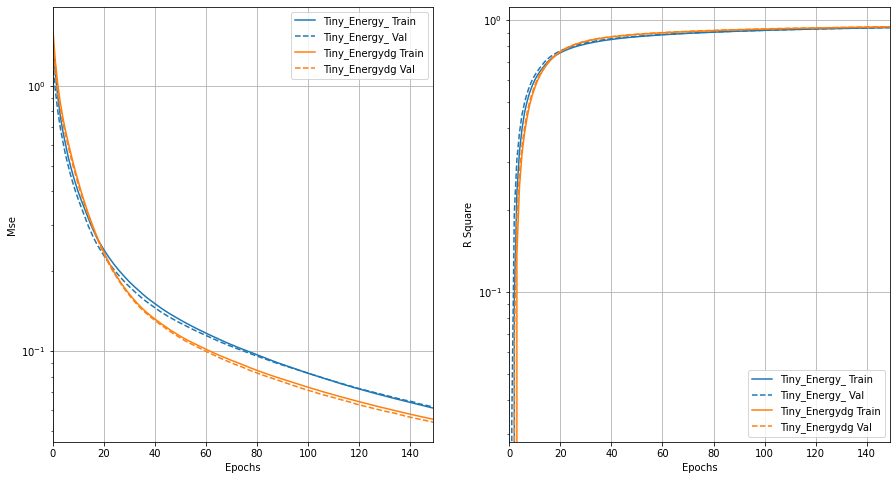

In [15]:
import tensorflow_docs as tfdocs
import matplotlib.pyplot as plt
import tensorflow_docs.plots

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(sgd_histories)

plt.subplot(1, 2, 2)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(sgd_histories)

### Tiny Model with Adam Optimizer

In [14]:
from keras.optimizers import Adam

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=100000, decay_rate=1, staircase=False)

tiny_model_Energy_.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
)

tiny_model_EnergyDG.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
)

In [55]:
adam_histories = {}

# TODO : optimize patience parameter via Optuna.
# this callback is used to do early stopping in case val_loss doesn't improve for 10 epochs
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# HUGO TODO : fine tune gradient/model hyperparameters via Optuna, epochs is model hyperparam, batch_size is stochastic descent hyperparameter
# number of instances to be used to compute gradient update
# nb : n_epochs
adam_histories['tiny_Energy_'] = tiny_model_Energy_.fit(X_train, y_train[:, 0], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 0]), callbacks=[es])
adam_histories['tiny_EnergyDG'] = tiny_model_EnergyDG.fit(X_train, y_train[:, 1], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 1]), callbacks=[es])


Epoch 1/150
19/19 [==============================] - 0s 7ms/step - loss: 0.0500 - mse: 0.0500 - r_square: 0.9500 - val_loss: 0.0335 - val_mse: 0.0335 - val_r_square: 0.9665
Epoch 2/150
19/19 [==============================] - 0s 2ms/step - loss: 0.0308 - mse: 0.0308 - r_square: 0.9692 - val_loss: 0.0246 - val_mse: 0.0246 - val_r_square: 0.9754
Epoch 3/150
19/19 [==============================] - 0s 2ms/step - loss: 0.0220 - mse: 0.0220 - r_square: 0.9780 - val_loss: 0.0184 - val_mse: 0.0184 - val_r_square: 0.9816
Epoch 4/150
19/19 [==============================] - 0s 2ms/step - loss: 0.0171 - mse: 0.0171 - r_square: 0.9829 - val_loss: 0.0151 - val_mse: 0.0151 - val_r_square: 0.9849
Epoch 5/150
19/19 [==============================] - 0s 2ms/step - loss: 0.0141 - mse: 0.0141 - r_square: 0.9859 - val_loss: 0.0127 - val_mse: 0.0127 - val_r_square: 0.9873
Epoch 6/150
19/19 [==============================] - 0s 2ms/step - loss: 0.0120 - mse: 0.0120 - r_square: 0.9880 - val_loss: 0.0114 - v

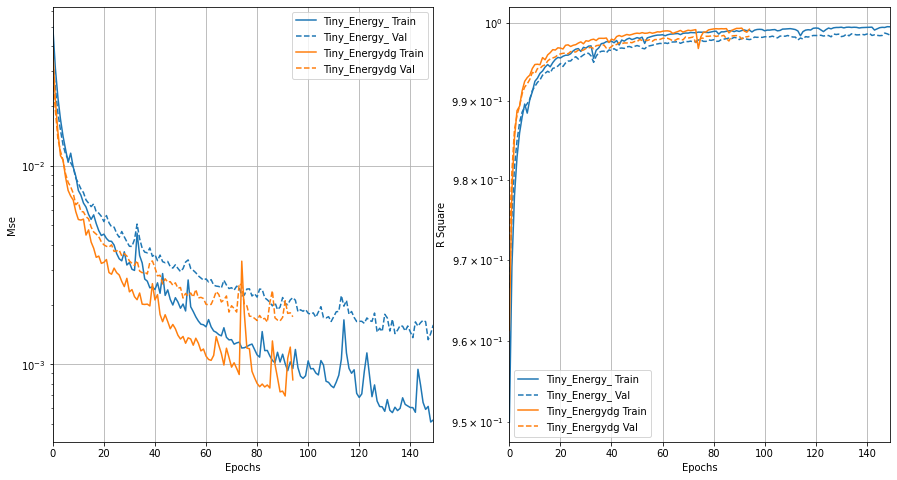

In [56]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(adam_histories)

plt.subplot(1, 2, 2)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(adam_histories)

### Fat Neural Network 

In [57]:
fat_model_Energy_ = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_dim=33),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(1)
])

fat_model_EnergyDG = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_dim=33),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(512, activation='relu', input_dim=512),
    keras.layers.Dense(1)
])

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

fat_model_Energy_.compile(
    loss='mse', 
    optimizer=SGD(learning_rate=1e-3, momentum=0), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
) 

fat_model_EnergyDG.compile(
    loss='mse', 
    optimizer=SGD(learning_rate=1e-3, momentum=0), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
) 

(9005, 33) (9005, 2) (1158, 33) (1158, 2)


In [58]:
sgd_histories['fat_Energy_'] = fat_model_Energy_.fit(X_train, y_train[:, 0], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 0]))
sgd_histories['fat_EnergyDG'] = fat_model_EnergyDG.fit(X_train, y_train[:, 1], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 1]))

Epoch 1/150
19/19 [==============================] - 1s 26ms/step - loss: 0.9829 - mse: 0.9829 - r_square: 0.0171 - val_loss: 0.9439 - val_mse: 0.9439 - val_r_square: 0.0561
Epoch 2/150
19/19 [==============================] - 0s 18ms/step - loss: 0.9212 - mse: 0.9212 - r_square: 0.0788 - val_loss: 0.8891 - val_mse: 0.8891 - val_r_square: 0.1109
Epoch 3/150
19/19 [==============================] - 0s 18ms/step - loss: 0.8684 - mse: 0.8684 - r_square: 0.1316 - val_loss: 0.8386 - val_mse: 0.8386 - val_r_square: 0.1614
Epoch 4/150
19/19 [==============================] - 0s 18ms/step - loss: 0.8191 - mse: 0.8191 - r_square: 0.1809 - val_loss: 0.7952 - val_mse: 0.7952 - val_r_square: 0.2048
Epoch 5/150
19/19 [==============================] - 0s 18ms/step - loss: 0.7765 - mse: 0.7765 - r_square: 0.2235 - val_loss: 0.7522 - val_mse: 0.7522 - val_r_square: 0.2478
Epoch 6/150
19/19 [==============================] - 0s 17ms/step - loss: 0.7341 - mse: 0.7341 - r_square: 0.2659 - val_loss: 0.71

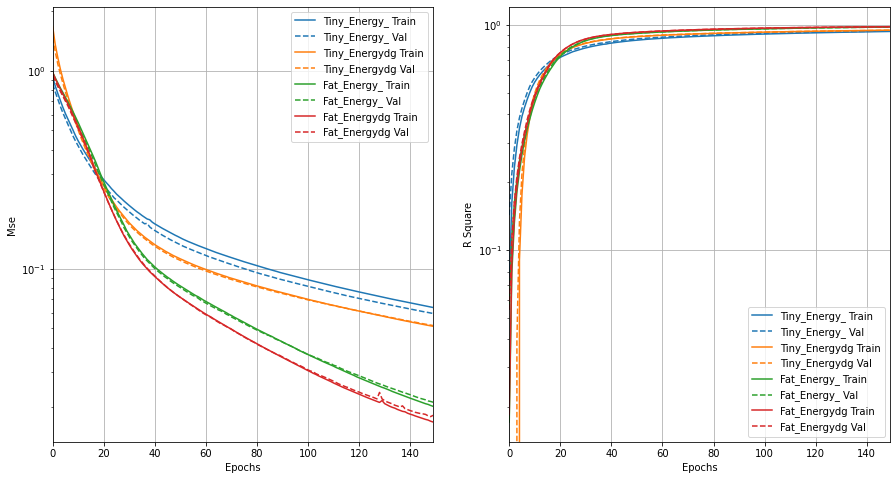

In [65]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(sgd_histories)

plt.subplot(1, 2, 2)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(sgd_histories)

In [61]:
fat_model_Energy_.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
)

fat_model_EnergyDG.compile(
    loss='mse', 
    optimizer=Adam(lr_schedule), 
    metrics=['mse', tfa.metrics.r_square.RSquare()]     # HUGO TODO : fine tune gradient hyperparameters via Optuna
)

In [62]:
adam_histories['fat_Energy_'] = fat_model_Energy_.fit(X_train, y_train[:, 0], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 0]))
adam_histories['fat_EnergyDG'] = fat_model_EnergyDG.fit(X_train, y_train[:, 1], epochs=150, batch_size=500, validation_data=(X_val, y_val[:, 1]))

Epoch 1/150
19/19 [==============================] - 1s 24ms/step - loss: 0.6569 - mse: 0.6569 - r_square: 0.3431 - val_loss: 0.1122 - val_mse: 0.1122 - val_r_square: 0.8878
Epoch 2/150
19/19 [==============================] - 0s 21ms/step - loss: 0.0872 - mse: 0.0872 - r_square: 0.9128 - val_loss: 0.0373 - val_mse: 0.0373 - val_r_square: 0.9627
Epoch 3/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0286 - mse: 0.0286 - r_square: 0.9714 - val_loss: 0.0168 - val_mse: 0.0168 - val_r_square: 0.9832
Epoch 4/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0112 - mse: 0.0112 - r_square: 0.9888 - val_loss: 0.0083 - val_mse: 0.0083 - val_r_square: 0.9917
Epoch 5/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0061 - mse: 0.0061 - r_square: 0.9939 - val_loss: 0.0059 - val_mse: 0.0059 - val_r_square: 0.9941
Epoch 6/150
19/19 [==============================] - 0s 19ms/step - loss: 0.0044 - mse: 0.0044 - r_square: 0.9956 - val_loss: 0.00

In [2]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='mse')
plotter.plot(adam_histories)

plt.subplot(1, 2, 2)
#plt.yscale("log")
plotter = tfdocs.plots.HistoryPlotter(metric='r_square')
plotter.plot(adam_histories)

NameError: name 'plt' is not defined